In [1]:
import numpy as np
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment
from gillespy2 import ODECSolver, ODESolver, SSACSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# devils Parameter Approximation

This notebook is used to calibrate a initial values which approximately match the results given in *Cunningham, Calum X., et al. "Quantifying 25 years of disease‐caused declines in Tasmanian devil populations: host density drives spatial pathogen spread." Ecology Letters 24.5 (2021): 958-969.*  The objective of this notebook is to gain an "eyeball approximation" of reasonable starting values to serve as input for more sophisticated inferencing.

In [2]:
class Devilsv101(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="devils_v1.0")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="r", expression="1"))
        self.add_parameter(Parameter(name="K", expression="217"))
        self.add_parameter(Parameter(name="ds", expression="0.22"))
        self.add_parameter(Parameter(name="dI", expression="1.28"))
        self.add_parameter(Parameter(name="L", expression=".75"))
        # self.add_parameter(Parameter(name="sigma", expression="0.5"))
        # self.add_parameter(Parameter(name="p", expression="0.6"))
        self.add_parameter(Parameter(name="k0", expression="4"))
        # self.add_parameter(Parameter(name="vf", expression="1"))
        # self.add_parameter(Parameter(name="vt", expression="0"))

        # Variables (initial values adjusted to observed data)
        self.add_species(Species(name="S", initial_value=0, mode="discrete"))
        self.add_species(Species(name="E", initial_value=0, mode="discrete"))
        self.add_species(Species(name="I", initial_value=0, mode="discrete"))
        # self.add_species(Species(name="W", initial_value=0, mode="discrete"))
#         self.add_species(Species(name="R", initial_value=0, mode="discrete"))
        self.add_species(Species(name="Devils", initial_value=0, mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1, 'Devils': 1}, propensity_function="r*(S+E+I)*(1-(S+E+I)/K)"))
#         self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1}, propensity_function="r*S*(1-S/K)"))
#         self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1}, rate=self.listOfParameters['r']))
#         self.add_reaction(Reaction(name='infect', reactants={'S':1}, products={'I':1}, rate=self.listOfParameters['infection']))
        self.add_reaction(Reaction(name="death_S", reactants={'S': 1, 'Devils': 1}, products={}, propensity_function="ds*S"))
        self.add_reaction(Reaction(name="transmission", reactants={'S': 1}, products={'E': 1}, propensity_function="k0*S*I/(S+E+I)"))
        self.add_reaction(Reaction(name="death_E", reactants={'Devils': 1, 'E': 1}, products={}, propensity_function="ds*E"))
        self.add_reaction(Reaction(name="latency", reactants={'E': 1}, products={'I': 1}, propensity_function="E/L"))
        # self.add_reaction(Reaction(name="vaccine_failure", reactants={'W': 1}, products={'E': 1}, propensity_function="k0*sigma*W*I/(S+E+I+W+R)"))
        self.add_reaction(Reaction(name="death_I", reactants={'I': 1, 'Devils': 1}, products={}, propensity_function="dI*I"))
        # self.add_reaction(Reaction(name="death_W", reactants={'W': 1}, products={}, propensity_function="ds*W"))
#         self.add_reaction(Reaction(name="death_R", reactants={'Devils': 1, 'R': 1}, products={}, propensity_function="ds*R"))

        # # Event Triggers
        # vaccination_trig = EventTrigger(expression="t >= vt+vf", initial_value=False, persistent=False)

        # # Event Assignments
        # vaccination_assign_1 = EventAssignment(variable="vt", expression="vt+1")
        # vaccination_assign_2 = EventAssignment(variable="W", expression="W+(S*p)")
        # vaccination_assign_3 = EventAssignment(variable="S", expression="S*(1-p)")

        # # Events
        # self.add_event(Event(name="vaccination", trigger=vaccination_trig, assignments=[vaccination_assign_1, vaccination_assign_2, vaccination_assign_3], delay=None, priority="0", use_values_from_trigger_time=True))

        # Timespan
        self.timespan(np.arange(0, 8, 0.1)) # month data tspan
#         self.timespan(np.arange(0, 60, 1)) # month data tspan
#         self.timespan(np.arange(0, 21, 1)) # year data tspan

In [3]:
model = Devilsv101()

## Read in observed data

In [4]:
import pandas as pd

# pop_data = pd.read_csv('../month_data/Devils_Dataset__Population_1985-2020.csv')
pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
devil_pop = np.array(pop_data['Population'].iloc[:].values)
init_devils_pop = devil_pop[0]
dftd_pop = .1*init_devils_pop

# model.listOfSpecies['Devils'].initial_value = init_devils_pop
# model.listOfParameters['K'].initial_value = init_devils_pop

model.listOfSpecies['I'].initial_value = dftd_pop  # This will be overwritten by variables later
model.listOfSpecies['S'].initial_value = init_devils_pop - dftd_pop

# r_pop = init_devils_pop - init_dfdt_pop
# init_e_pop = 0
# init_s_pop = r_pop - init_e_pop
# model.listOfSpecies['S'].initial_value = init_s_pop
# model.listOfSpecies['E'].initial_value = init_e_pop

# obs = np.vstack([devil_pop, dfdt_pop]).reshape(1, 2, -1)
# print(obs)

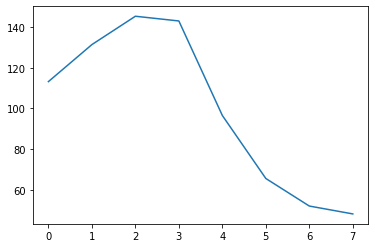

In [5]:
plt.plot(range(0,len(devil_pop)), devil_pop)
# plt.plot(range(0,len(dfdt_pop)), dfdt_pop)
# plt.plot(model.tspan, dfdt_pop[140:200])

## Configure Solver Widget

In [6]:
solver = ODECSolver(model, variable=True)

In [7]:
def f(L, k0, r, sTime, eTime, dI, ds):
#     time = range(241)
    title = 'Total Species for Time Range {0}-{1}'.format(sTime, eTime)
    print('=================================')
    print('| Time Range: {}-{}'.format(sTime, eTime))
    print('| -------------------------------')
    print('| Input Parameters:')
    print('| \tL: {}, k0: {}'.format(L, k0))
    print('| \tr: {}'.format(r))
    print('| -------------------------------')
#     print('| Initial Value of I: {}'.format(dfdt_pop[sTime]))
#     print('| -------------------------------')
#     print('| Ratio of dI:r:')
#     print('| \t{}:{}'.format(str(dI), str(r)))
    print('=================================')
    res, rc = solver.run(model=model, variables={'L':str(L), 'r':str(r), 'k0':str(k0), 'Devils':devil_pop[sTime], 'S':devil_pop[sTime]-dftd_pop,'dI': str(dI), 'ds': str(ds)}, t=(eTime-sTime), increment=1)

    if len(res) > 0:
            results_list = []
            for i in range(0, len(res)):
                temp = gillespy2.Trajectory(data=res[i], model=model, solver_name=solver.name, rc=rc)
                results_list.append(temp)

            results = gillespy2.Results(results_list)

    total_devils = np.add(results['I'], results['S'])
#     simulated_dfdt = plt.plot(range(sTime, eTime+1), results['I'], 'g', label='Simulated DFTD')
    simulated_devils = plt.plot(range(sTime, eTime+1), total_devils, 'b', label='Simulated Total')
#     expected_dfdt = plt.plot(range(sTime, eTime+1), dfdt_pop[sTime:eTime+1], '--g', label='Observed DFTD')
    expected_devils = plt.plot(range(sTime, eTime+1), devil_pop[sTime:eTime+1], '--b', label='Observed Total')
    plt.xlabel('month')
    plt.ylabel('population')
    plt.legend(loc='best')
    plt.title(title)
#     result_str = results['I'][-1]
#     result_str = 'DFTD Expected: {0} - Got: {1} -- '.format(dfdt_pop[eTime-1], results['I'][-1])
    result_str = 'TOTAL Expected: {0} - Got: {1}'.format(devil_pop[eTime-1], total_devils[-1])

    return result_str

In [8]:
# Create Widgets

dL = widgets.FloatSlider(min=0, max=10, step=0.1, value=0.75)
dk0 = widgets.FloatSlider(min=0, max=10, step=0.1, value=4)
dds = widgets.FloatSlider(min=.1, max=1, step=.01, value=0.22)
ddI = widgets.FloatSlider(min=.5, max=3, step=.01, value=1.28)
# dInfection = widgets.FloatSlider(min=0, max=.1, step=.001, value=0.024)
dr = widgets.FloatSlider(min=0.01, max=10, step=0.1, value=1)
dsTime = widgets.IntSlider(min=0, max=6, step=1, value=0)
deTime = widgets.IntSlider(min=1, max=7, step=1, value=7)

## Run the widget and attempt to calibrate model

In [9]:
# Run interactions
interact(f, L=dL, k0=dk0, r=dr, sTime=dsTime, eTime=deTime, dI=ddI, ds=dds)

interactive(children=(FloatSlider(value=0.75, description='L', max=10.0), FloatSlider(value=4.0, description='…

<function __main__.f(L, k0, r, sTime, eTime, dI, ds)>